# 02_DL_DMD_Forecast

Pronóstico de series de tiempo de precipitación con autoencoder y DMD

In [1]:
import pandas as pd
import numpy as np

# Leer los datos desde el archivo CSV
# Supongamos que el archivo CSV tiene N filas (observaciones) y P columnas (estaciones)
data_df = pd.read_csv(r'D:\11_Entorno_Desarrollo\UDD\captone_project\CAPSTONE_PROJECT\data\raw\precipitation_test.csv')

# Convertir el DataFrame a un array de NumPy
data = data_df.values

# Verificar la forma de los datos
print(data.shape)  # Esto imprimirá (N, P), donde N es el número de observaciones y P es el número de estaciones.
# Guardar los datos en formato .npy
np.save('precipitation_data.npy', data)

(1826, 30)


In [3]:
# Instalar pydmd si no está disponible
%pip install pydmd

  Using cached pydmd-2025.8.1-py3-none-any.whl.metadata (22 kB)
  Using cached h5netcdf-1.7.3-py3-none-any.whl.metadata (13 kB)
Using cached pydmd-2025.8.1-py3-none-any.whl (152 kB)
Using cached h5netcdf-1.7.3-py3-none-any.whl (56 kB)
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 16.7 MB/s  0:00:00

   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xarray]
   ------------- -------------------------- 1/3 [xa

In [4]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pydmd import DMD

# Parámetros del espacio latente
latent_dim = 100 # Ajustar la dimensión del espacio latente

In [5]:
# 1. Cargar y preparar los datos
X = np.load('precipitation_data.npy')  # [samples, stations]

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Definir el número de características (dimensión multivariada)
n_features = X.shape[1] # Dimensión de las series multivariadas
X_scaled = X_scaled[:, :n_features]  # Asegurarse de que X_scaled tiene m=150 series

# Reshape para el autoencoder
X_scaled = X_scaled.reshape(-1, 1, n_features)

In [6]:
# 2. Definir el Autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense

timesteps = X_scaled.shape[1]

input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)  # Encoder
encoded = Dense(latent_dim, activation='relu')(encoded)  # Latent space
decoded = Dense(64, activation='relu')(encoded)  # Decoder
decoded = RepeatVector(timesteps)(decoded)
decoded = LSTM(n_features, activation='sigmoid', return_sequences=True)(decoded)  # Output layer

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=1, shuffle=True)

Epoch 1/50
1826/1826 [==============================] - 14s 6ms/step - loss: 0.0044
Epoch 2/50
1826/1826 [==============================] - 14s 6ms/step - loss: 0.0044
Epoch 2/50
1826/1826 [==============================] - 11s 6ms/step - loss: 8.3721e-04
Epoch 3/50
1826/1826 [==============================] - 11s 6ms/step - loss: 8.3721e-04
Epoch 3/50
1826/1826 [==============================] - 11s 6ms/step - loss: 6.1354e-04
Epoch 4/50
1826/1826 [==============================] - 11s 6ms/step - loss: 6.1354e-04
Epoch 4/50
1826/1826 [==============================] - 11s 6ms/step - loss: 5.1648e-04
Epoch 5/50
1826/1826 [==============================] - 11s 6ms/step - loss: 5.1648e-04
Epoch 5/50
1826/1826 [==============================] - 11s 6ms/step - loss: 5.2221e-04
Epoch 6/50
1826/1826 [==============================] - 11s 6ms/step - loss: 5.2221e-04
Epoch 6/50
1826/1826 [==============================] - 11s 6ms/step - loss: 5.0820e-04
Epoch 7/50
1826/1826 [==================

58/58 [==============================] - 1s 3ms/step


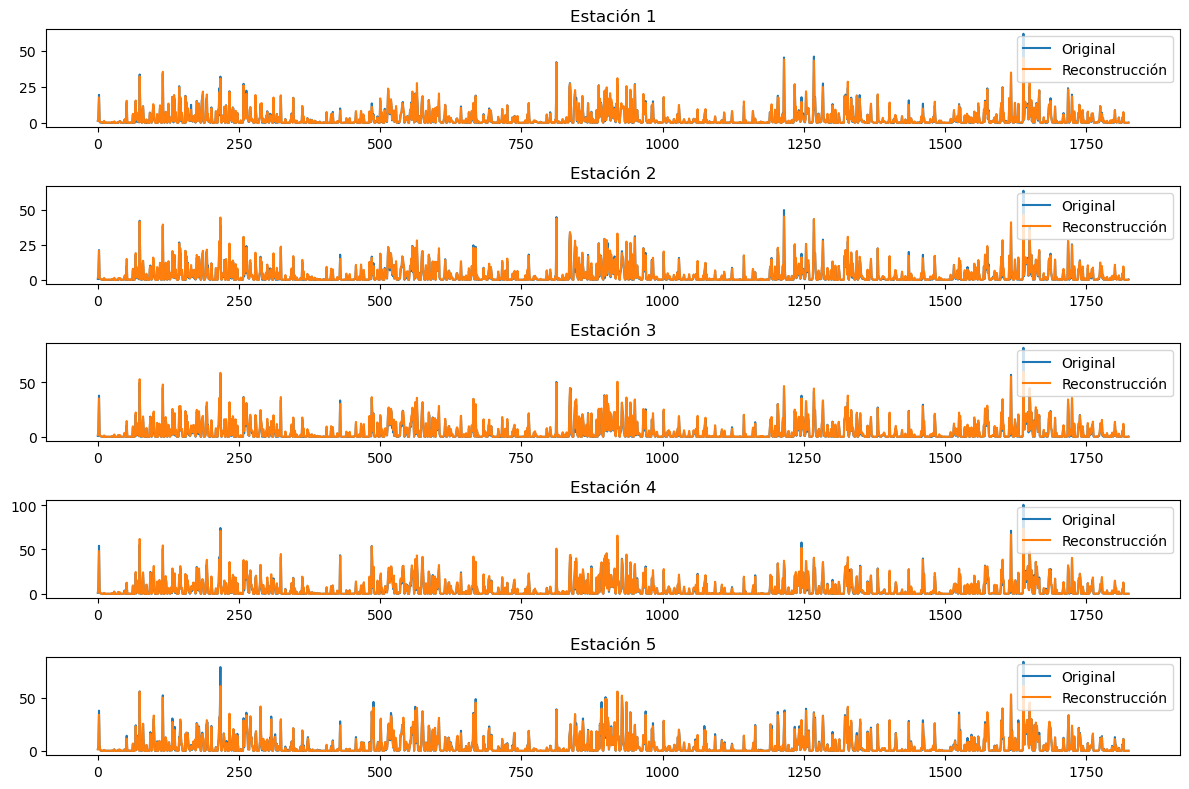

In [7]:
# 6. Verificar las reconstrucciones del autoencoder
X_reconstructed_new = autoencoder.predict(X_scaled)

# Revertir el reshape y la normalización
X_reconstructed_new = X_reconstructed_new.reshape(-1, n_features)
X_scaled = X_scaled.reshape(-1, n_features)
X_reconstructed_new = scaler.inverse_transform(X_reconstructed_new)
X_scaled = scaler.inverse_transform(X_scaled)

# 6.1. Graficar las series originales y reconstruidas para comparar

# Definir el número de estaciones a mostrar en las gráficas
num_stations_to_plot = 5  # Cambiar este valor para regular el número de estaciones que se muestran

plt.figure(figsize=(12, 8))
for i in range(min(n_features, num_stations_to_plot)):
    plt.subplot(num_stations_to_plot, 1, i + 1)
    plt.plot(X_scaled[:, i], label='Original')
    plt.plot(X_reconstructed_new[:, i], label='Reconstrucción')
    plt.title(f'Estación {i + 1}')
    plt.legend()
plt.tight_layout()
plt.show()

In [8]:
#Guardar los pesos del autoencoder
autoencoder.save_weights('autoencoder_weights.h5')

In [10]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pydmd import DMD
import pandas as pd

# Parámetros
#latent_dim = 100  # Dimensión del espacio latente
svd_rank = int(latent_dim / 1)  # SVD rank para DMD
k = 300  # Horizonte de predicción
ruido_ampl =1* 1e-2  # Amplitud del ruido a agregar
delay = 0  # Tamaño del retraso (ventana de tiempo)

# Establecer semilla para reproducibilidad
seed = 124
np.random.seed(seed)

# 1. Cargar y preparar los datos
X = np.load('precipitation_data.npy')  # [samples, stations]

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape para el autoencoder
n_features = X_scaled.shape[1]
X_scaled = X_scaled.reshape(-1, 1, n_features)

# 2. Definir el Autoencoder y cargar los pesos
timesteps = X_scaled.shape[1]
input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)  # Encoder
encoded = Dense(latent_dim, activation='relu')(encoded)  # Latent space
decoded = Dense(64, activation='relu')(encoded)  # Decoder
decoded = RepeatVector(timesteps)(decoded)
decoded = LSTM(n_features, activation='sigmoid', return_sequences=True)(decoded)  # Output layer

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Cargar los pesos entrenados previamente
autoencoder.load_weights('autoencoder_weights.h5')

# 3. Obtener la representación latente
encoder_model = Model(inputs=input_layer, outputs=encoded)
X_latent = encoder_model.predict(X_scaled).reshape(-1, latent_dim)  # Dimensión: (num_samples, latent_dim)

# 4. Aplicar DMD a la representación latente
dmd = DMD(svd_rank=svd_rank)  # Ajustar el svd_rank para DMD
dmd.fit(X_latent.T)  # Ajustar DMD

# 5. Realizar predicción con k pasos hacia adelante usando DMD y ventana de retraso
X_pred_latent = X_latent[-delay:, :].T  # Inicializar con la ventana de retraso

for _ in range(k):
    next_step = dmd.predict(X_pred_latent[:, -1].reshape(-1, 1)).real
    next_step += ruido_ampl * np.random.randn(latent_dim, 1)  # Agregar ruido pequeño
    X_pred_latent = np.hstack((X_pred_latent, next_step))

X_pred_latent = X_pred_latent[:, delay:]  # Quitar los vectores originales de la ventana de retraso

# 6. Reconstruir la serie predicha
decoder_model = Model(inputs=encoded, outputs=decoded)
X_pred_latent_reconstructed = []

for i in range(k):
    latent_segment = X_pred_latent[:, i].reshape(1, -1)
    reconstruction = decoder_model.predict(latent_segment).reshape(-1, n_features)
    X_pred_latent_reconstructed.append(reconstruction)

X_pred_latent_reconstructed = np.vstack(X_pred_latent_reconstructed)

# Invertir la normalización
X_pred_latent_reconstructed = scaler.inverse_transform(X_pred_latent_reconstructed)

58/58 [==============================] - 1s 5ms/step


c:\Users\cesar.godoy\anaconda3\envs\capstone\lib\site-packages\pydmd\snapshots.py:73: UserWarning: Input data condition number 2.871860454112991e+34. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


1/1 [==============================] - 0s 42ms/step


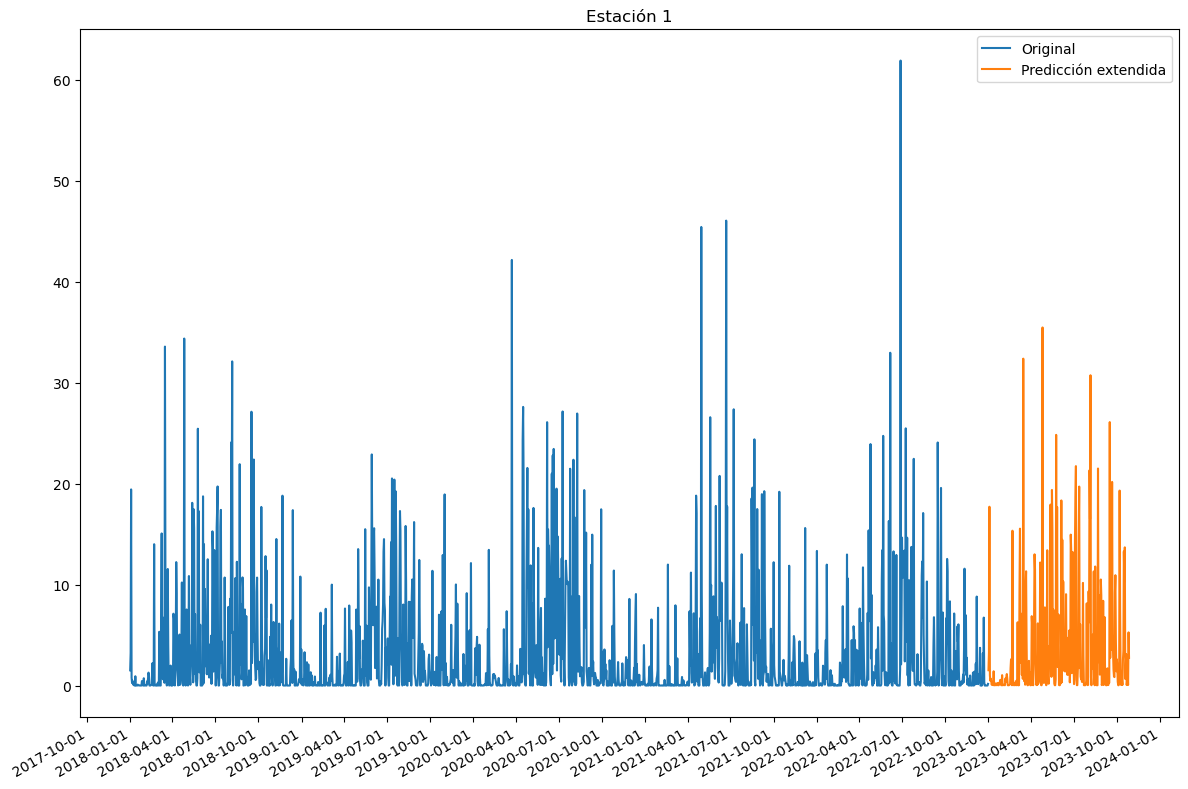

In [11]:
# 7. Graficar los resultados
import matplotlib.dates as mdates

# 1. Gráfico de series temporales con fechas
num_stations_to_plot = 1  # Número de estaciones a visualizar
start_date = "2018-01-01"  # Fecha de inicio

# Generar fechas para el eje x
dates = pd.date_range(start=start_date, periods=X.shape[0] + X_pred_latent_reconstructed.shape[0])

plt.figure(figsize=(12, 8))
s=0
# Graficar cada estación
for i in range(num_stations_to_plot):
    plt.subplot(num_stations_to_plot, 1, i + 1)
    plt.plot(dates[:X.shape[0]], X[:, i+ s], label='Original')
    plt.plot(dates[X.shape[0]:], X_pred_latent_reconstructed[:, i], label='Predicción extendida')
    plt.title(f'Estación {i+s + 1}')
    plt.legend()

    # Formatear las fechas en el eje x
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Espaciar las marcas de fechas cada 3 meses
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

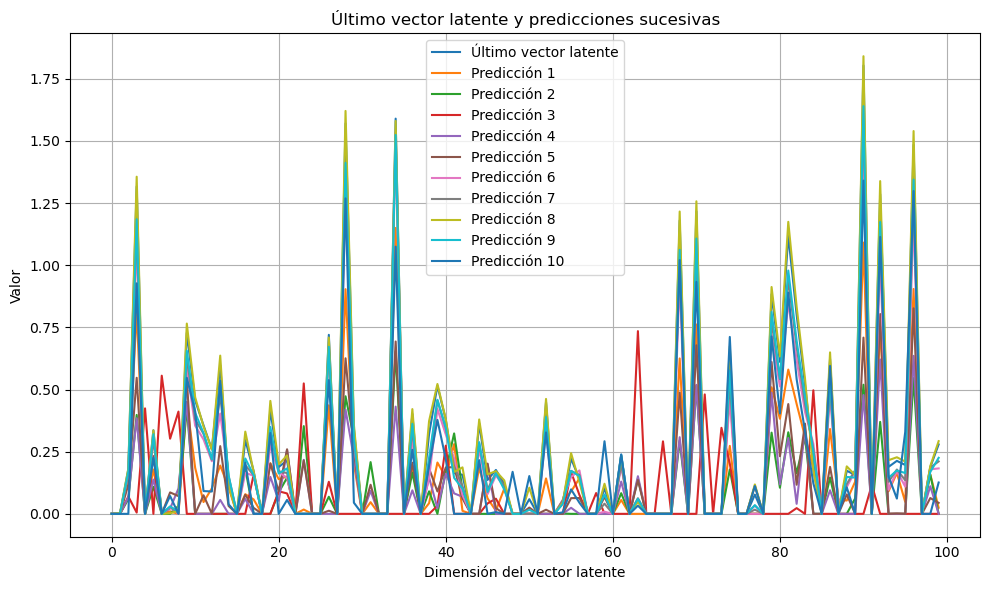

In [12]:
# 8. Graficar el último vector latente y las predicciones sucesivas
num_vectors_to_plot = 10  # Número de vectores latentes a visualizar
plt.figure(figsize=(10, 6))
plt.plot(X_latent[-1, :], label='Último vector latente')

for idx in range(min(k, num_vectors_to_plot)):
    plt.plot(X_pred_latent[:, idx], label=f'Predicción {idx + 1}')

plt.title('Último vector latente y predicciones sucesivas')
plt.xlabel('Dimensión del vector latente')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()